In [1]:
##if using Anaconda (on Anaconda terminal)
#conda install -c conda-forge xgboost 
#pip install xgboost

#import sys
#!{sys.executable} -m pip install xgboost

In [2]:
from sklearn.exceptions import ConvergenceWarning
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from preprocessing import split_X_y, create_train_test_splits, ncv_results_to_df, choose_split
from model_optimization import optimize_one_model
from plotting import plot_metric_boxplots, compare_mean_mccs
from nested_cv_pipeline import run_all_classifiers
from simple_cv_pipeline import optimize_hyperparameters
from final_model import build_final_model, test_final_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [3]:
DATA_DIR = os.path.join(os.getcwd(), 'data')

## Import Labeled Data

In [4]:
#data = pd.read_csv(os.path.join(DATA_DIR, 'ind4_clustering_results.csv.gz'), compression='gzip')
data = pd.read_csv(os.path.join(DATA_DIR, 'ind4_clustering_results_var_genes.csv.gz'), compression='gzip')
data

,ORM1,ORM2,MMP3,FDCSP,S100A7,FABP7,KRT81,DCN,IL1B,AREG,...,MRGPRX4,C2CD4B,CTD.2012K14.8,CCR10,FAS,ADORA2B,PRMT9,PHGDH,HOXA4,cluster_label
0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,B
1,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.159752,1.159752,0.0,0.000000,0.0,B
2,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,L1
3,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.231624,0.000000,...,0.0,0.0,0.0,0.0,1.231624,0.000000,0.0,0.962358,0.0,B
4,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.198887,0.0,L1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4009,0.00000,0.000000,0.000000,0.0,0.000000,1.382332,3.756037,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.382332,0.0,L1
4010,0.00000,0.000000,3.002545,0.0,0.000000,0.000000,0.000000,0.0,1.139851,1.139851,...,0.0,0.0,0.0,0.0,1.139851,0.000000,0.0,0.000000,0.0,B
4011,0.00000,0.000000,0.000000,0.0,1.729568,1.199697,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,L1
4012,2.44477,2.946953,0.000000,0.0,2.142408,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,1.388285,0.000000,0.0,0.000000,0.0,L2


L1              1931
B               1429
L2               572
Unclassified      82
Name: cluster_label, dtype: int64


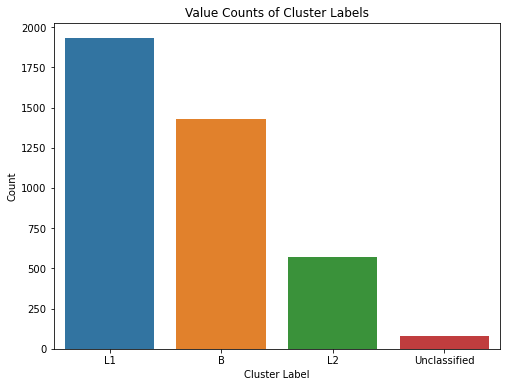

In [5]:
cluster_counts = data['cluster_label'].value_counts()
print(cluster_counts)

plt.figure(figsize=(8, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.xlabel('Cluster Label')
plt.ylabel('Count')
plt.title('Value Counts of Cluster Labels')
plt.show()

In [6]:
data.describe()

,ORM1,ORM2,MMP3,FDCSP,S100A7,FABP7,KRT81,DCN,IL1B,AREG,...,RP11.597D13.9,MRGPRX4,C2CD4B,CTD.2012K14.8,CCR10,FAS,ADORA2B,PRMT9,PHGDH,HOXA4
count,4014.000000,4014.000000,4014.000000,4014.000000,4014.000000,4014.000000,4014.000000,4014.000000,4014.000000,4014.000000,...,4014.000000,4014.000000,4014.000000,4014.000000,4014.000000,4014.000000,4014.000000,4014.000000,4014.000000,4014.000000
mean,0.142191,0.084910,0.297772,0.065054,0.488509,0.199051,0.159551,0.034415,0.279810,0.315602,...,0.004128,0.004331,0.004275,0.004063,0.004464,0.240907,0.068786,0.024694,0.412100,0.034093
std,0.696116,0.485980,0.856380,0.414117,1.078162,0.655485,0.587791,0.346617,0.779161,0.762863,...,0.066658,0.068425,0.069848,0.066387,0.072764,0.494458,0.261867,0.155206,0.592806,0.180004
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.877524,0.000000
max,6.762612,5.539486,6.572284,4.903337,5.591136,4.861639,5.166052,5.812831,5.654543,4.846035,...,1.493988,1.604655,1.778140,1.709633,1.842913,2.938584,1.879372,2.390354,2.622593,2.246530


In [7]:
zeros_count = (data == 0).sum()
print(zeros_count)

ORM1             3749
ORM2             3857
MMP3             3421
FDCSP            3883
S100A7           3103
                 ... 
ADORA2B          3729
PRMT9            3904
PHGDH            2538
HOXA4            3858
cluster_label       0
Length: 2001, dtype: int64


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4014 entries, 0 to 4013
Columns: 2001 entries, ORM1 to cluster_label
dtypes: float64(2000), object(1)
memory usage: 61.3+ MB


## PreProcessing

Split X, y and turn labels from string to int with values in range (0, n_classes-1). Also isolate a 30% part of the data as a hold out test set, that will be used to test the generalization ability of the final model. Remove the Unclassified cells, which are of non-epithelial nature.

In [9]:
data = data[~data['cluster_label'].str.contains('Unclassified')]
data = data.reset_index(drop=True)

In [10]:
X_init, y_init = split_X_y(data)
X_init


,ORM1,ORM2,MMP3,FDCSP,S100A7,FABP7,KRT81,DCN,IL1B,AREG,...,RP11.597D13.9,MRGPRX4,C2CD4B,CTD.2012K14.8,CCR10,FAS,ADORA2B,PRMT9,PHGDH,HOXA4
0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
1,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.159752,1.159752,0.0,0.000000,0.0
2,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
3,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.231624,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.231624,0.000000,0.0,0.962358,0.0
4,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.198887,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3927,0.00000,0.000000,0.000000,0.0,0.000000,1.382332,3.756037,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.382332,0.0
3928,0.00000,0.000000,3.002545,0.0,0.000000,0.000000,0.000000,0.0,1.139851,1.139851,...,0.0,0.0,0.0,0.0,0.0,1.139851,0.000000,0.0,0.000000,0.0
3929,0.00000,0.000000,0.000000,0.0,1.729568,1.199697,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
3930,2.44477,2.946953,0.000000,0.0,2.142408,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.388285,0.000000,0.0,0.000000,0.0


In [11]:
y_init = pd.DataFrame(y_init)
y_init

,0
0,2
1,2
2,0
3,2
4,0
...,...
3927,0
3928,2
3929,0
3930,1


In [12]:
# create train-test sets for final model testing
splits = create_train_test_splits(X_init, y_init)


# 1st train-test split

In [13]:
X, X_test, y, y_test = choose_split(splits, 0)

(2752, 2000)
(1180, 2000)
(2752, 1)
(1180, 1)


In [14]:
X

,ORM1,ORM2,MMP3,FDCSP,S100A7,FABP7,KRT81,DCN,IL1B,AREG,...,RP11.597D13.9,MRGPRX4,C2CD4B,CTD.2012K14.8,CCR10,FAS,ADORA2B,PRMT9,PHGDH,HOXA4
0,0.000000,0.0,0.000000,0.0,0.552270,0.905991,0.0,0.0,0.0,0.552270,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.905991,0.000000
1,0.000000,0.0,0.000000,0.0,2.577097,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
2,0.651338,0.0,0.651338,0.0,0.000000,0.000000,0.0,0.0,0.0,0.651338,...,0.0,0.0,0.0,0.0,0.0,0.651338,0.000000,0.0,1.042469,0.651338
3,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,4.587950,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
4,0.000000,0.0,0.000000,0.0,2.937808,3.821794,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1.173814,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2747,0.000000,0.0,4.237859,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
2748,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.911606,0.0,0.000000,0.911606
2749,0.000000,0.0,0.000000,0.0,2.691593,0.927567,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.927567,0.000000
2750,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.650511,0.000000,0.0,0.000000,0.000000


### NestedCV to optimize each model and compare them

In [15]:
X.shape

(2752, 2000)

In [16]:
X.loc[[0,1,2,3]]


,ORM1,ORM2,MMP3,FDCSP,S100A7,FABP7,KRT81,DCN,IL1B,AREG,...,RP11.597D13.9,MRGPRX4,C2CD4B,CTD.2012K14.8,CCR10,FAS,ADORA2B,PRMT9,PHGDH,HOXA4
0,0.000000,0.0,0.000000,0.0,0.552270,0.905991,0.0,0.0,0.0,0.552270,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.905991,0.000000
1,0.000000,0.0,0.000000,0.0,2.577097,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
2,0.651338,0.0,0.651338,0.0,0.000000,0.000000,0.0,0.0,0.0,0.651338,...,0.0,0.0,0.0,0.0,0.0,0.651338,0.0,0.0,1.042469,0.651338
3,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,4.587950,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000


In [17]:
results, params_dict = run_all_classifiers(X,y)

Starting NCV experiment for classifier svm


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Starting NCV experiment for classifier lr


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Starting NCV experiment for classifier gnb


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Starting NCV experiment for classifier rf


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Starting NCV experiment for classifier xgb


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [18]:
for key, value in params_dict.items():
    print(f'Params for classifier {key}')
    for idx, param in enumerate(value):
        print(f'Params of trial {idx}: {param}')

Params for classifier svm
Params of trial 0: {'c_svm': 0.9460418298423572, 'gamma_svm': 0.004619213144696522}
Params of trial 1: {'c_svm': 0.3728977817217844, 'gamma_svm': 0.019303169396678782}
Params of trial 2: {'c_svm': 0.8967112492538016, 'gamma_svm': 0.12032792353976625}
Params of trial 3: {'c_svm': 0.0918573676172642, 'gamma_svm': 0.015972213013474384}
Params of trial 4: {'c_svm': 0.7856006307832272, 'gamma_svm': 0.0019623539763029695}
Params of trial 5: {'c_svm': 0.9318072973025859, 'gamma_svm': 0.21711224787058916}
Params of trial 6: {'c_svm': 0.5548454170592717, 'gamma_svm': 0.0059821788435528815}
Params of trial 7: {'c_svm': 0.798538520477302, 'gamma_svm': 0.009177601394539808}
Params of trial 8: {'c_svm': 0.6902707502814955, 'gamma_svm': 0.0032049447522629927}
Params of trial 9: {'c_svm': 0.9733784045199249, 'gamma_svm': 0.007693131841664031}
Params of trial 10: {'c_svm': 0.7474102456892281, 'gamma_svm': 0.0038964153717663125}
Params of trial 11: {'c_svm': 0.7291962922232383

#### Metrics to compare the algorithms

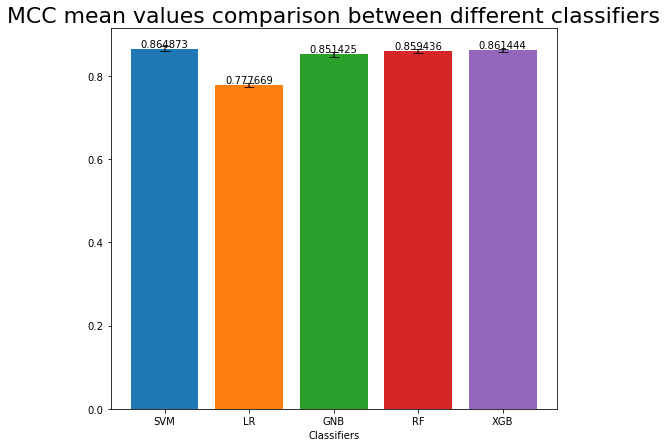

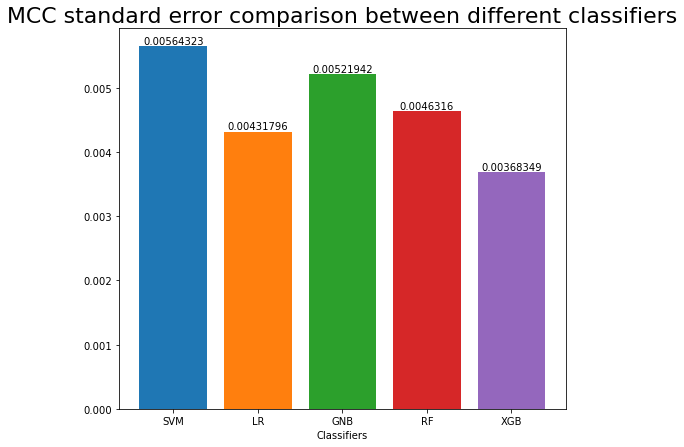

{'svm': 0.8648734058435872,
 'lr': 0.7776693520147893,
 'gnb': 0.8514246568484379,
 'rf': 0.8594359223865337,
 'xgb': 0.8614435563590765}

In [19]:
mccs_dict = compare_mean_mccs(results)
mccs_dict

In [20]:
results_df = ncv_results_to_df(results)
results_df

,Classifier,Metric,Outer Loop,Value
0,svm,F1_weighted,1,0.905779
1,svm,F1_weighted,2,0.918697
2,svm,F1_weighted,3,0.896112
3,svm,F1_weighted,4,0.926014
4,svm,F1_weighted,5,0.905357
...,...,...,...,...
595,xgb,Balanced_Accuracy,11,0.888970
596,xgb,Balanced_Accuracy,12,0.869815
597,xgb,Balanced_Accuracy,13,0.875648
598,xgb,Balanced_Accuracy,14,0.896605


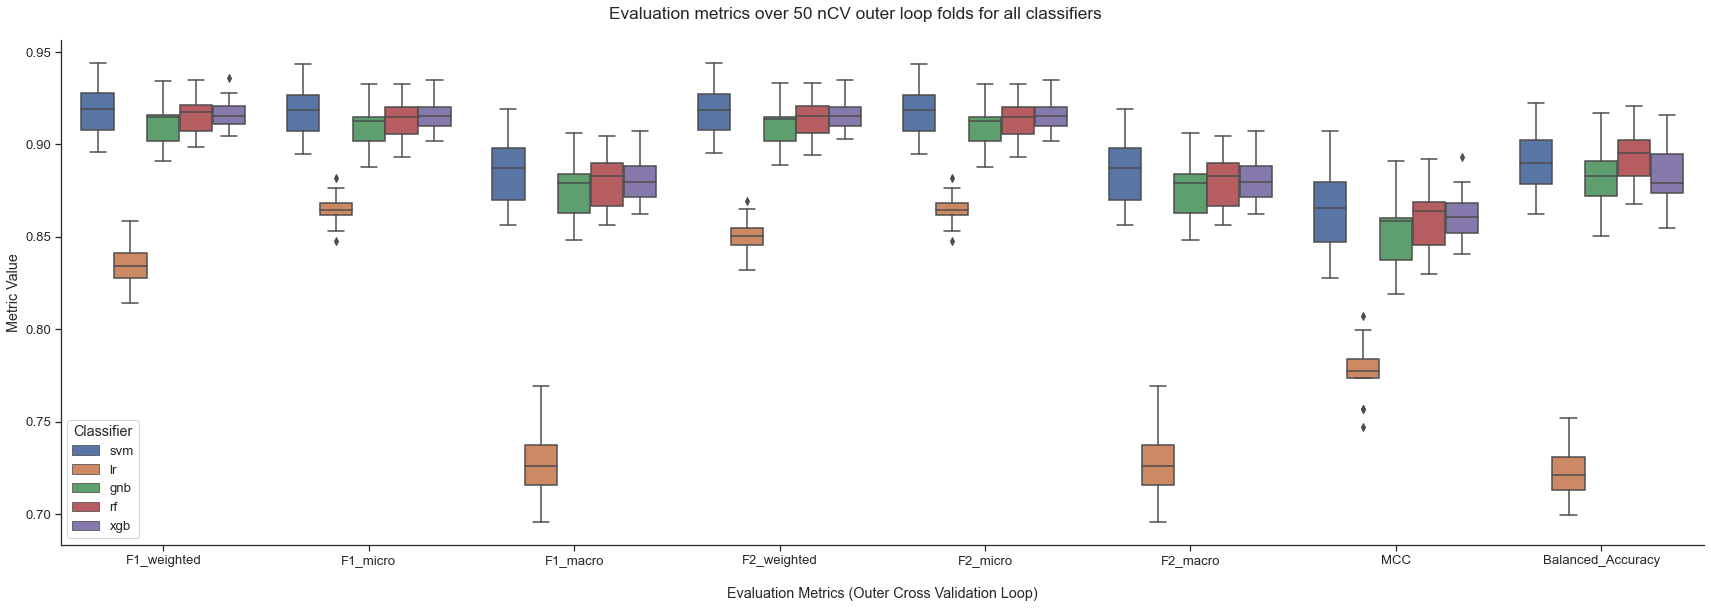

In [21]:
plot_metric_boxplots(results_df)

### 5-fold cross validation to optimize hyperparameters

In [22]:
best_params, best_value = optimize_hyperparameters(X, y)

  0%|          | 0/50 [00:00<?, ?it/s]

Best Hyperparameters: {'c_svm': 0.38571007878975583, 'gamma_svm': 0.052276127333619006}
Best Value: 0.8724329327795376


## Build final model

In [23]:
final_model, svd = build_final_model(X, y, best_params)
final_model

OneVsRestClassifier(estimator=SVC(C=0.38571007878975583,
                                  gamma=0.052276127333619006, max_iter=1000,
                                  random_state=42),
                    n_jobs=-1)

## Test on held-out test set

In [24]:
X_test

,ORM1,ORM2,MMP3,FDCSP,S100A7,FABP7,KRT81,DCN,IL1B,AREG,...,RP11.597D13.9,MRGPRX4,C2CD4B,CTD.2012K14.8,CCR10,FAS,ADORA2B,PRMT9,PHGDH,HOXA4
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1.424330,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.581527,0.000000
2,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,2.109562,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.228141,0.0,0.0,0.000000,1.228141
3,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1.918477,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
4,0.0,0.0,0.0,0.0,1.085065,0.000000,0.000000,0.0,0.000000,3.115999,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,2.193441,0.0,0.0,1.296188,0.000000
1176,0.0,0.0,0.0,0.0,1.236227,0.000000,0.000000,0.0,0.000000,3.858820,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
1177,0.0,0.0,0.0,0.0,2.026303,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.600620,0.000000
1178,0.0,0.0,0.0,0.0,0.000000,1.382332,3.756037,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.382332,0.000000


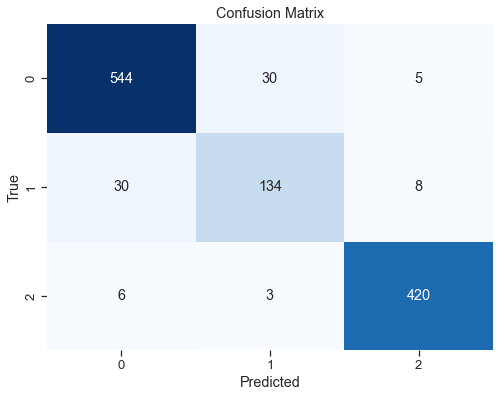

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       579
           1       0.80      0.78      0.79       172
           2       0.97      0.98      0.97       429

    accuracy                           0.93      1180
   macro avg       0.90      0.90      0.90      1180
weighted avg       0.93      0.93      0.93      1180



In [25]:
test_final_model(final_model, X_test, y_test, svd)

# 2nd train-test split

In [26]:
X, X_test, y, y_test = choose_split(splits, 1)

(2752, 2000)
(1180, 2000)
(2752, 1)
(1180, 1)


In [27]:
X

,ORM1,ORM2,MMP3,FDCSP,S100A7,FABP7,KRT81,DCN,IL1B,AREG,...,RP11.597D13.9,MRGPRX4,C2CD4B,CTD.2012K14.8,CCR10,FAS,ADORA2B,PRMT9,PHGDH,HOXA4
0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.562601,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,1.562601,0.000000
1,0.0,0.0,0.000000,4.462703,2.001093,0.000000,1.811187,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.823924,0.000000
2,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.146400,1.1464,0.0,0.000000,0.000000
3,0.0,0.0,0.000000,0.000000,0.540579,0.540579,0.000000,0.0,0.000000,0.540579,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.000000,0.000000
4,0.0,0.0,0.000000,0.000000,0.000000,0.983546,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.983546,0.0000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2747,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.000000,0.000000
2748,0.0,0.0,0.000000,0.000000,0.835956,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.000000,0.835956
2749,0.0,0.0,1.681657,0.000000,0.000000,0.000000,0.000000,0.0,1.681657,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,1.681657,0.000000
2750,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.000000,0.000000


### NestedCV to optimize each model and compare them

In [28]:
X.shape

(2752, 2000)

In [29]:
X.loc[[0,1,2,3]]


,ORM1,ORM2,MMP3,FDCSP,S100A7,FABP7,KRT81,DCN,IL1B,AREG,...,RP11.597D13.9,MRGPRX4,C2CD4B,CTD.2012K14.8,CCR10,FAS,ADORA2B,PRMT9,PHGDH,HOXA4
0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.562601,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,1.562601,0.0
1,0.0,0.0,0.0,4.462703,2.001093,0.000000,1.811187,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.823924,0.0
2,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.1464,1.1464,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.000000,0.540579,0.540579,0.000000,0.0,0.0,0.540579,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.000000,0.0


In [30]:
results, params_dict = run_all_classifiers(X,y)

Starting NCV experiment for classifier svm


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Starting NCV experiment for classifier lr


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Starting NCV experiment for classifier gnb


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Starting NCV experiment for classifier rf


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Starting NCV experiment for classifier xgb


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [31]:
for key, value in params_dict.items():
    print(f'Params for classifier {key}')
    for idx, param in enumerate(value):
        print(f'Params of trial {idx}: {param}')

Params for classifier svm
Params of trial 0: {'c_svm': 0.8034544108709601, 'gamma_svm': 0.18989183348033617}
Params of trial 1: {'c_svm': 0.9875720717007753, 'gamma_svm': 0.0032947165770610275}
Params of trial 2: {'c_svm': 0.40953524109773004, 'gamma_svm': 0.28321886893836085}
Params of trial 3: {'c_svm': 0.5948570699297551, 'gamma_svm': 0.14939292702452778}
Params of trial 4: {'c_svm': 0.433564578759448, 'gamma_svm': 0.14159090336124402}
Params of trial 5: {'c_svm': 0.9083179086717649, 'gamma_svm': 0.0020314206131093015}
Params of trial 6: {'c_svm': 0.6916768887648668, 'gamma_svm': 0.02958856224758626}
Params of trial 7: {'c_svm': 0.5364302741456051, 'gamma_svm': 0.2616531384750757}
Params of trial 8: {'c_svm': 0.45884585301544134, 'gamma_svm': 0.21890775737633394}
Params of trial 9: {'c_svm': 0.6144437632898281, 'gamma_svm': 0.04481390829932746}
Params of trial 10: {'c_svm': 0.5940579323013444, 'gamma_svm': 0.05404100504820513}
Params of trial 11: {'c_svm': 0.4953893031842122, 'gamma

#### Metrics to compare the algorithms

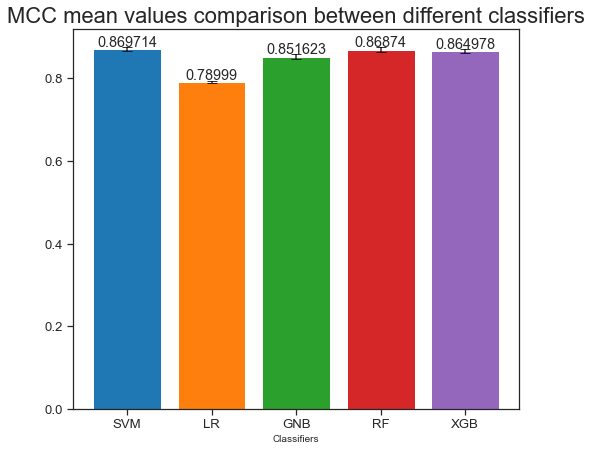

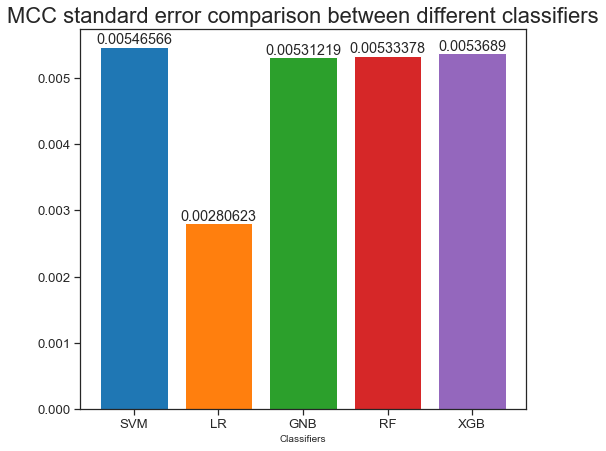

{'svm': 0.8697142512211581,
 'lr': 0.7899900949637123,
 'gnb': 0.8516233117567785,
 'rf': 0.8687396090673359,
 'xgb': 0.8649776681645046}

In [32]:
mccs_dict = compare_mean_mccs(results)
mccs_dict

In [33]:
results_df = ncv_results_to_df(results)
results_df

,Classifier,Metric,Outer Loop,Value
0,svm,F1_weighted,1,0.915803
1,svm,F1_weighted,2,0.940232
2,svm,F1_weighted,3,0.920057
3,svm,F1_weighted,4,0.935461
4,svm,F1_weighted,5,0.904231
...,...,...,...,...
595,xgb,Balanced_Accuracy,11,0.911113
596,xgb,Balanced_Accuracy,12,0.875031
597,xgb,Balanced_Accuracy,13,0.881481
598,xgb,Balanced_Accuracy,14,0.893179


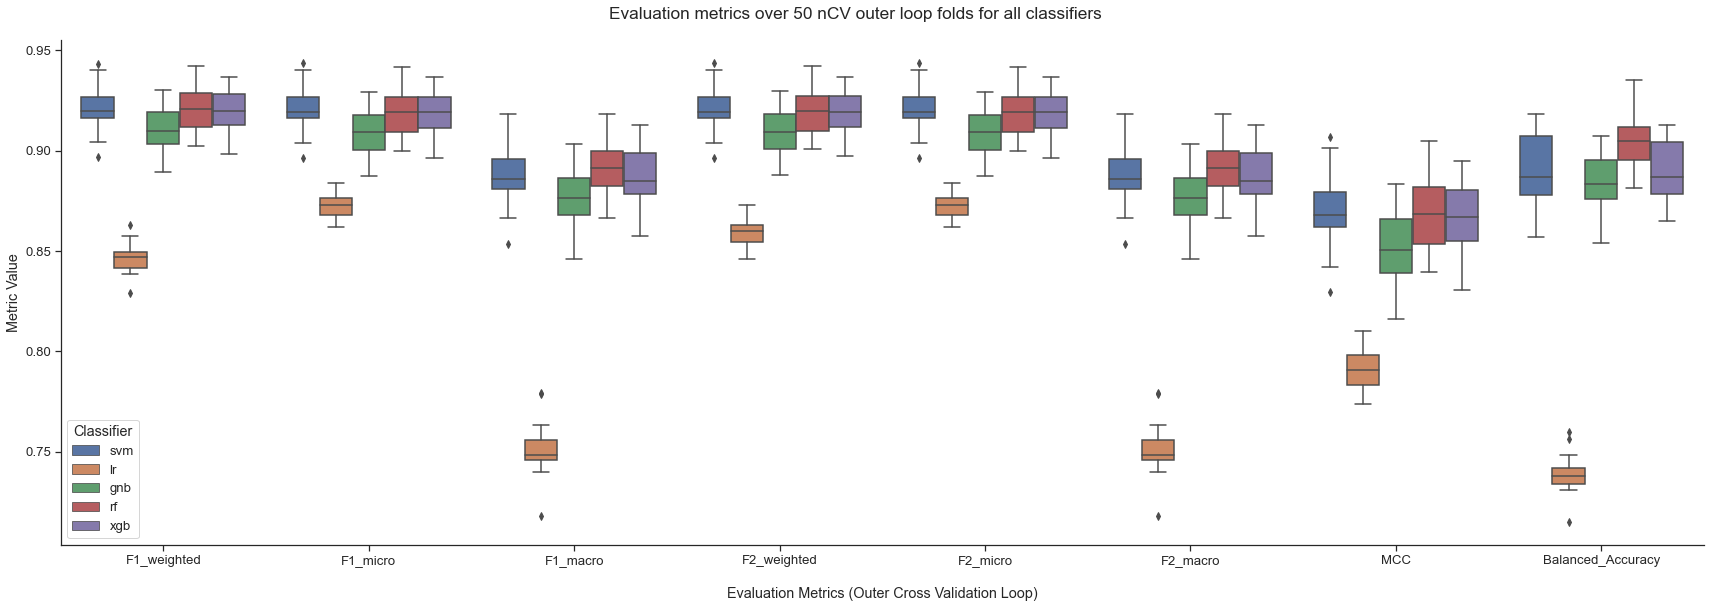

In [34]:
plot_metric_boxplots(results_df)

### 5-fold cross validation to optimize hyperparameters

In [35]:
best_params, best_value = optimize_hyperparameters(X, y)

  0%|          | 0/50 [00:00<?, ?it/s]

Best Hyperparameters: {'c_svm': 0.31081384980446375, 'gamma_svm': 0.06624595478336587}
Best Value: 0.8737890653141125


## Build final model

In [36]:
final_model, svd = build_final_model(X, y, best_params)
final_model

OneVsRestClassifier(estimator=SVC(C=0.31081384980446375,
                                  gamma=0.06624595478336587, max_iter=1000,
                                  random_state=42),
                    n_jobs=-1)

## Test on held-out test set

In [37]:
X_test

,ORM1,ORM2,MMP3,FDCSP,S100A7,FABP7,KRT81,DCN,IL1B,AREG,...,RP11.597D13.9,MRGPRX4,C2CD4B,CTD.2012K14.8,CCR10,FAS,ADORA2B,PRMT9,PHGDH,HOXA4
0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,2.307958,0.000000,...,0.0,0.0,0.0,1.709633,0.0,0.000000,0.0,0.0,0.000000,0.0
1,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,1.803416,1.803416,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
2,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.515931,0.0
3,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.499158,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
4,0.000000,0.000000,0.0,0.0,0.579828,0.579828,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,0.000000,1.874373,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
1176,0.887387,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,3.044659,...,0.0,0.0,0.0,0.000000,0.0,0.887387,0.0,0.0,0.000000,0.0
1177,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,1.931731,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
1178,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,1.143916,0.0


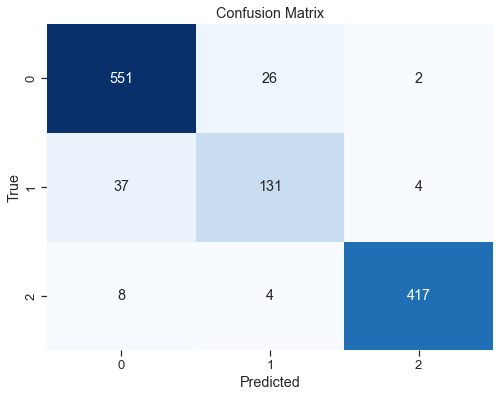

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       579
           1       0.81      0.76      0.79       172
           2       0.99      0.97      0.98       429

    accuracy                           0.93      1180
   macro avg       0.91      0.90      0.90      1180
weighted avg       0.93      0.93      0.93      1180



In [38]:
test_final_model(final_model, X_test, y_test, svd)

# 3rd train-test split

In [39]:
X, X_test, y, y_test = choose_split(splits, 2)

(2752, 2000)
(1180, 2000)
(2752, 1)
(1180, 1)


In [40]:
X

,ORM1,ORM2,MMP3,FDCSP,S100A7,FABP7,KRT81,DCN,IL1B,AREG,...,RP11.597D13.9,MRGPRX4,C2CD4B,CTD.2012K14.8,CCR10,FAS,ADORA2B,PRMT9,PHGDH,HOXA4
0,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
1,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
2,2.874238,1.98334,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.127845,1.127845,0.0,0.000000,0.000000
3,0.000000,0.00000,1.796171,0.0,0.000000,0.000000,0.000000,0.0,3.937014,2.452001,...,0.0,0.0,0.0,0.0,0.0,0.984140,0.750003,0.0,0.000000,0.750003
4,0.000000,0.00000,0.000000,0.0,1.502892,2.440956,1.010631,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.010631,0.000000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2747,0.000000,0.00000,0.000000,0.0,1.565114,2.587423,0.000000,0.0,2.587423,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
2748,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1.098079,...,0.0,0.0,0.0,0.0,0.0,1.098079,0.000000,0.0,1.098079,0.000000
2749,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.701552,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
2750,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000


### NestedCV to optimize each model and compare them

In [41]:
X.shape

(2752, 2000)

In [42]:
X.loc[[0,1,2,3]]


,ORM1,ORM2,MMP3,FDCSP,S100A7,FABP7,KRT81,DCN,IL1B,AREG,...,RP11.597D13.9,MRGPRX4,C2CD4B,CTD.2012K14.8,CCR10,FAS,ADORA2B,PRMT9,PHGDH,HOXA4
0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
1,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
2,2.874238,1.98334,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.127845,1.127845,0.0,0.0,0.000000
3,0.000000,0.00000,1.796171,0.0,0.0,0.0,0.0,0.0,3.937014,2.452001,...,0.0,0.0,0.0,0.0,0.0,0.984140,0.750003,0.0,0.0,0.750003


In [43]:
results, params_dict = run_all_classifiers(X,y)

Starting NCV experiment for classifier svm


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Starting NCV experiment for classifier lr


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Starting NCV experiment for classifier gnb


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Starting NCV experiment for classifier rf


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Starting NCV experiment for classifier xgb


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [44]:
for key, value in params_dict.items():
    print(f'Params for classifier {key}')
    for idx, param in enumerate(value):
        print(f'Params of trial {idx}: {param}')

Params for classifier svm
Params of trial 0: {'c_svm': 0.7631658262018408, 'gamma_svm': 0.5636468181664366}
Params of trial 1: {'c_svm': 0.766606408407079, 'gamma_svm': 0.09029095707477622}
Params of trial 2: {'c_svm': 0.6024460058394839, 'gamma_svm': 0.0030112630973093916}
Params of trial 3: {'c_svm': 0.5006401938465217, 'gamma_svm': 0.5216261382575226}
Params of trial 4: {'c_svm': 0.8859402313552599, 'gamma_svm': 0.18649058563945392}
Params of trial 5: {'c_svm': 0.22397188614246757, 'gamma_svm': 0.4602638007055818}
Params of trial 6: {'c_svm': 0.3622278759458454, 'gamma_svm': 0.005936331215446181}
Params of trial 7: {'c_svm': 0.4251380136143983, 'gamma_svm': 0.004820546998492577}
Params of trial 8: {'c_svm': 0.38270584788130907, 'gamma_svm': 0.005616392329229026}
Params of trial 9: {'c_svm': 0.16851476174778726, 'gamma_svm': 0.006843606484584747}
Params of trial 10: {'c_svm': 0.8146521068580148, 'gamma_svm': 0.07829141184231625}
Params of trial 11: {'c_svm': 0.21086203868850417, 'gam

#### Metrics to compare the algorithms

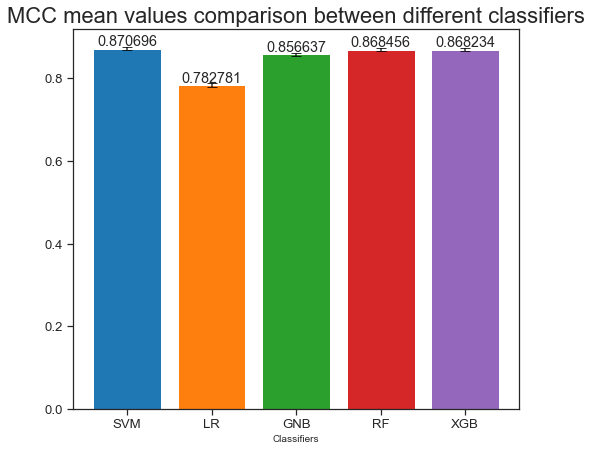

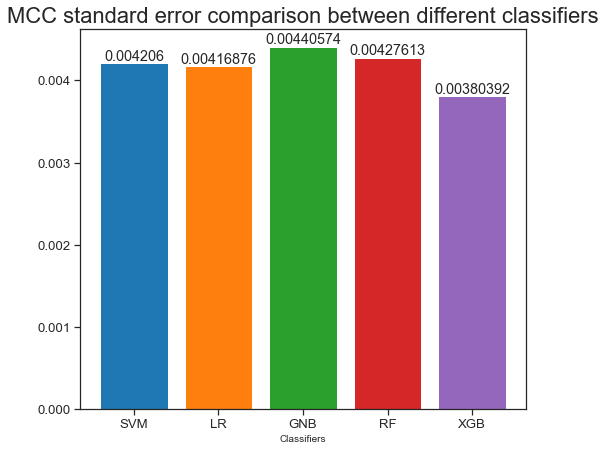

{'svm': 0.8706962862454259,
 'lr': 0.7827812341247716,
 'gnb': 0.8566369377516313,
 'rf': 0.8684558363758322,
 'xgb': 0.8682339309682986}

In [45]:
mccs_dict = compare_mean_mccs(results)
mccs_dict

In [46]:
results_df = ncv_results_to_df(results)
results_df

,Classifier,Metric,Outer Loop,Value
0,svm,F1_weighted,1,0.930281
1,svm,F1_weighted,2,0.922552
2,svm,F1_weighted,3,0.920796
3,svm,F1_weighted,4,0.911697
4,svm,F1_weighted,5,0.923307
...,...,...,...,...
595,xgb,Balanced_Accuracy,11,0.830716
596,xgb,Balanced_Accuracy,12,0.884815
597,xgb,Balanced_Accuracy,13,0.888642
598,xgb,Balanced_Accuracy,14,0.891944


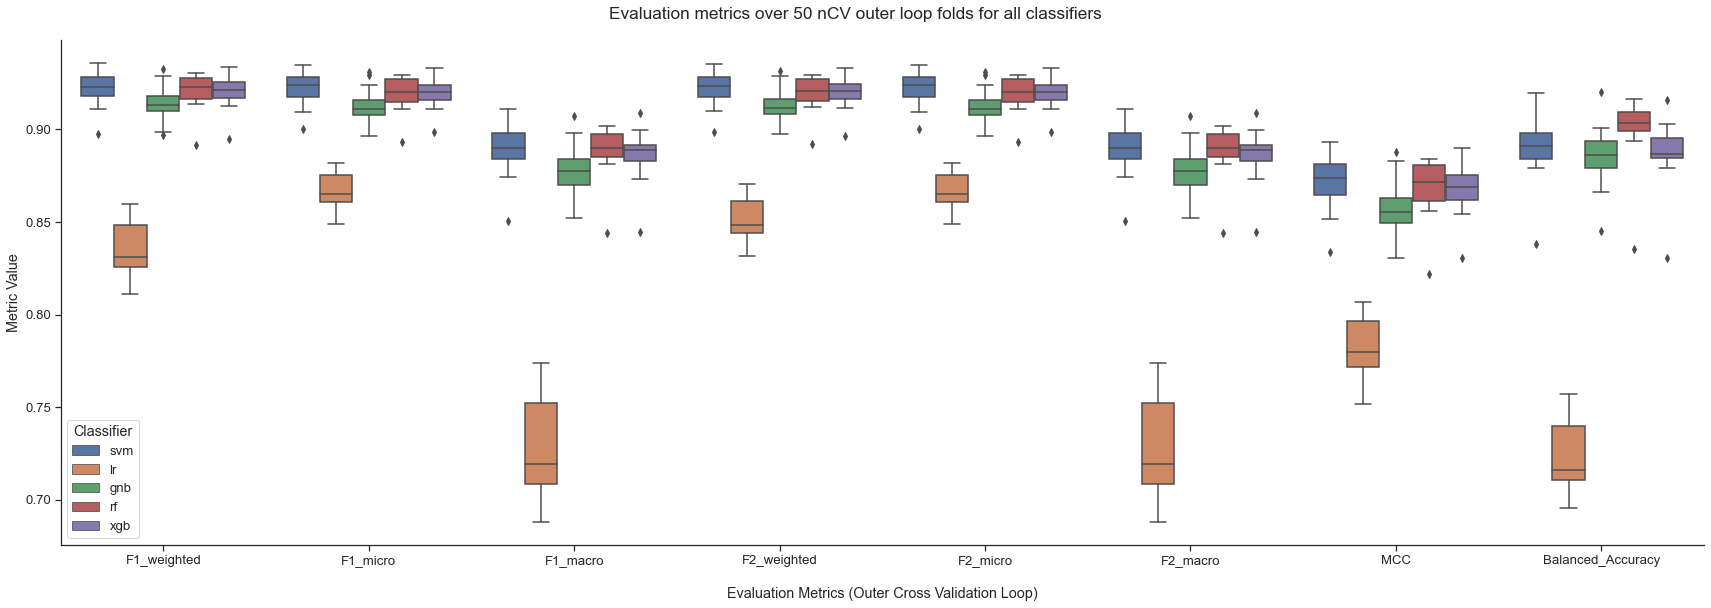

In [47]:
plot_metric_boxplots(results_df)

### 5-fold cross validation to optimize hyperparameters

In [48]:
best_params, best_value = optimize_hyperparameters(X, y)

  0%|          | 0/50 [00:00<?, ?it/s]

Best Hyperparameters: {'c_svm': 0.7881917691917928, 'gamma_svm': 0.22679043255015896}
Best Value: 0.870080342761916


## Build final model

In [49]:
final_model, svd = build_final_model(X, y, best_params)
final_model

OneVsRestClassifier(estimator=SVC(C=0.7881917691917928,
                                  gamma=0.22679043255015896, max_iter=1000,
                                  random_state=42),
                    n_jobs=-1)

## Test on held-out test set

In [50]:
X_test

,ORM1,ORM2,MMP3,FDCSP,S100A7,FABP7,KRT81,DCN,IL1B,AREG,...,RP11.597D13.9,MRGPRX4,C2CD4B,CTD.2012K14.8,CCR10,FAS,ADORA2B,PRMT9,PHGDH,HOXA4
0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.957287,...,0.957287,0.0,0.0,0.0,0.0,0.957287,0.000000,0.0,1.437283,0.0
1,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.025192,0.000000,...,0.000000,0.0,0.0,0.0,0.0,1.520663,0.000000,0.0,1.025192,0.0
2,0.0,0.0,3.497801,0.0,0.000000,0.000000,0.000000,0.0,0.848060,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
3,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1.516347,...,0.000000,0.0,0.0,0.0,0.0,0.000000,1.021651,0.0,0.000000,0.0
4,0.0,0.0,0.000000,0.0,1.888551,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.752339,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,0.0,0.0,0.000000,0.0,2.674909,0.478801,0.000000,0.0,0.000000,0.801228,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.478801,0.0
1176,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
1177,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
1178,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.411411,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0


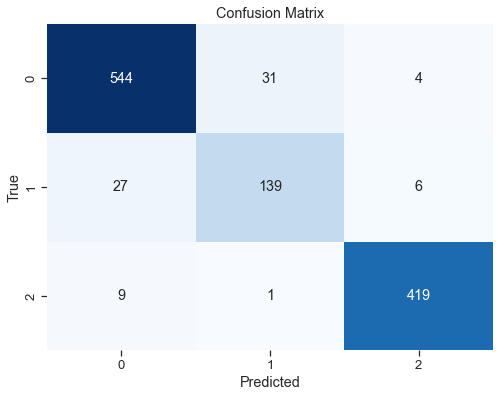

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       579
           1       0.81      0.81      0.81       172
           2       0.98      0.98      0.98       429

    accuracy                           0.93      1180
   macro avg       0.91      0.91      0.91      1180
weighted avg       0.93      0.93      0.93      1180



In [51]:
test_final_model(final_model, X_test, y_test, svd)

# 4th train-test split

In [52]:
X, X_test, y, y_test = choose_split(splits, 3)

(2752, 2000)
(1180, 2000)
(2752, 1)
(1180, 1)


In [53]:
X

,ORM1,ORM2,MMP3,FDCSP,S100A7,FABP7,KRT81,DCN,IL1B,AREG,...,RP11.597D13.9,MRGPRX4,C2CD4B,CTD.2012K14.8,CCR10,FAS,ADORA2B,PRMT9,PHGDH,HOXA4
0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.480339,0.0
1,0.0,0.0,0.000000,0.0,1.675631,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.895021,0.000000,0.000000,0.000000,0.0
2,0.0,0.0,0.721071,0.0,0.000000,1.837876,0.721071,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.721071,1.135674,0.0
3,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.923247,0.0,0.0,0.0,0.000000,0.923247,0.923247,0.000000,0.000000,0.0
4,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.132385,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,1.989127,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2747,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1.918477,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2748,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2749,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,1.842913,0.000000,0.000000,0.000000,0.000000,0.0
2750,0.0,0.0,0.000000,0.0,3.632967,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,1.627603,0.000000,0.000000,0.000000,0.0


### NestedCV to optimize each model and compare them

In [54]:
X.shape

(2752, 2000)

In [55]:
X.loc[[0,1,2,3]]


,ORM1,ORM2,MMP3,FDCSP,S100A7,FABP7,KRT81,DCN,IL1B,AREG,...,RP11.597D13.9,MRGPRX4,C2CD4B,CTD.2012K14.8,CCR10,FAS,ADORA2B,PRMT9,PHGDH,HOXA4
0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,1.480339,0.0
1,0.0,0.0,0.000000,0.0,1.675631,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.895021,0.000000,0.000000,0.000000,0.0
2,0.0,0.0,0.721071,0.0,0.000000,1.837876,0.721071,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.721071,1.135674,0.0
3,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.923247,0.0,0.0,0.0,0.0,0.923247,0.923247,0.000000,0.000000,0.0


In [56]:
results, params_dict = run_all_classifiers(X,y)

Starting NCV experiment for classifier svm


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Starting NCV experiment for classifier lr


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Starting NCV experiment for classifier gnb


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Starting NCV experiment for classifier rf


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Starting NCV experiment for classifier xgb


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [57]:
for key, value in params_dict.items():
    print(f'Params for classifier {key}')
    for idx, param in enumerate(value):
        print(f'Params of trial {idx}: {param}')

Params for classifier svm
Params of trial 0: {'c_svm': 0.9742581769217378, 'gamma_svm': 0.0027977649045060507}
Params of trial 1: {'c_svm': 0.671217168845047, 'gamma_svm': 0.08224997354030214}
Params of trial 2: {'c_svm': 0.857834427320868, 'gamma_svm': 0.012894785443904147}
Params of trial 3: {'c_svm': 0.2316320368677173, 'gamma_svm': 0.25352588537747794}
Params of trial 4: {'c_svm': 0.4540788015411468, 'gamma_svm': 0.011056156101758212}
Params of trial 5: {'c_svm': 0.5022153100395821, 'gamma_svm': 0.006900671854028312}
Params of trial 6: {'c_svm': 0.44610307572683505, 'gamma_svm': 0.0035500022320854923}
Params of trial 7: {'c_svm': 0.16153940319040683, 'gamma_svm': 0.021442112111907892}
Params of trial 8: {'c_svm': 0.7256174344533203, 'gamma_svm': 0.0035035406233620684}
Params of trial 9: {'c_svm': 0.20511234514891288, 'gamma_svm': 0.007236488088452482}
Params of trial 10: {'c_svm': 0.18312960356792188, 'gamma_svm': 0.020126396011135944}
Params of trial 11: {'c_svm': 0.85812963716800

#### Metrics to compare the algorithms

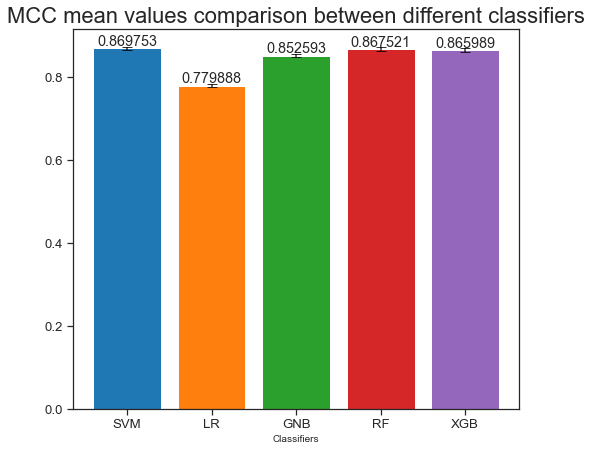

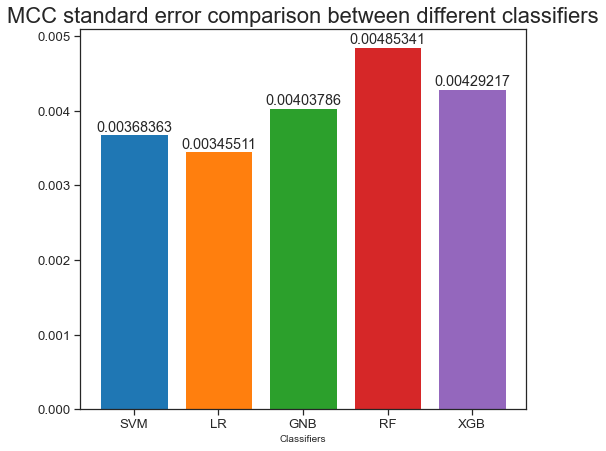

{'svm': 0.8697533017028577,
 'lr': 0.7798884461255007,
 'gnb': 0.8525925475638829,
 'rf': 0.8675213997108806,
 'xgb': 0.8659891303503288}

In [58]:
mccs_dict = compare_mean_mccs(results)
mccs_dict

In [59]:
results_df = ncv_results_to_df(results)
results_df

,Classifier,Metric,Outer Loop,Value
0,svm,F1_weighted,1,0.926295
1,svm,F1_weighted,2,0.930096
2,svm,F1_weighted,3,0.919872
3,svm,F1_weighted,4,0.921698
4,svm,F1_weighted,5,0.932472
...,...,...,...,...
595,xgb,Balanced_Accuracy,11,0.892623
596,xgb,Balanced_Accuracy,12,0.862747
597,xgb,Balanced_Accuracy,13,0.876080
598,xgb,Balanced_Accuracy,14,0.908920


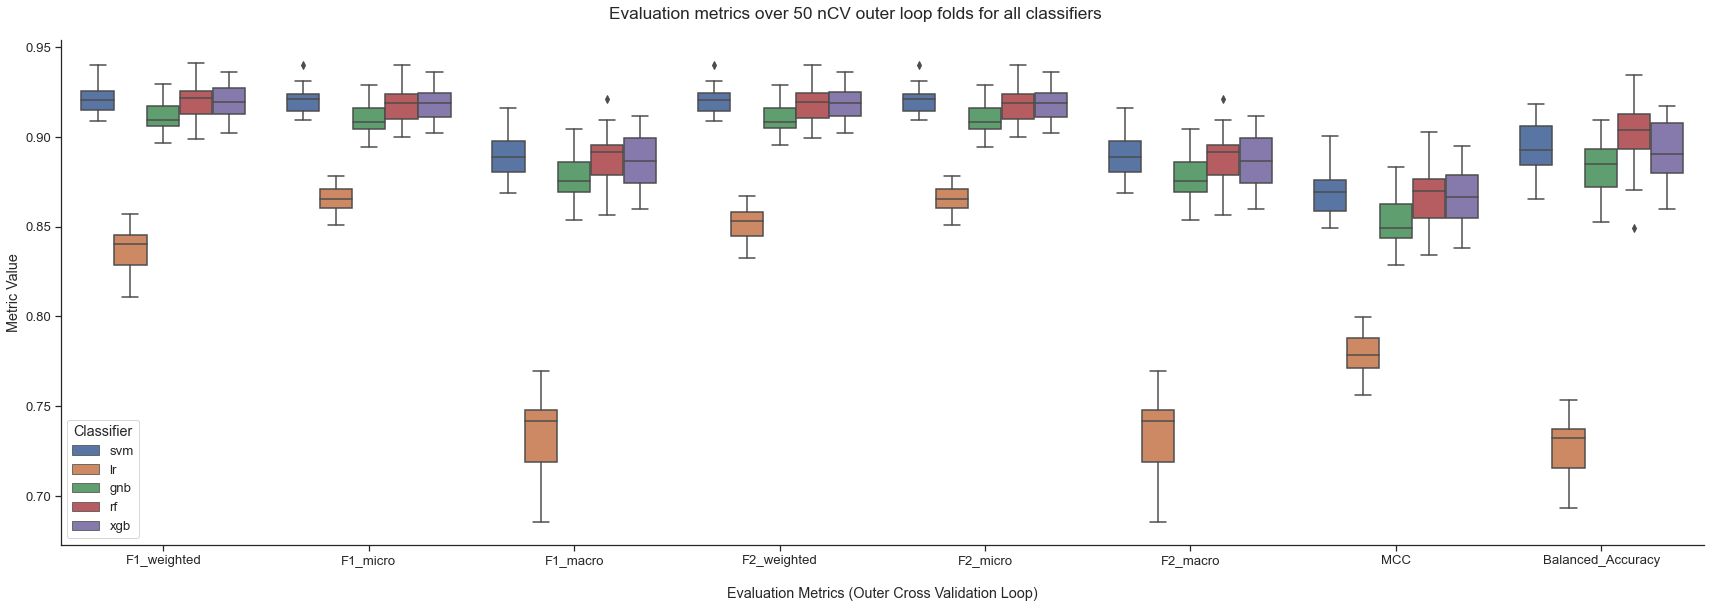

In [60]:
plot_metric_boxplots(results_df)

### 5-fold cross validation to optimize hyperparameters

In [61]:
best_params, best_value = optimize_hyperparameters(X, y)

  0%|          | 0/50 [00:00<?, ?it/s]

Best Hyperparameters: {'c_svm': 0.8792459938063422, 'gamma_svm': 0.07745407278200162}
Best Value: 0.8760223554289357


## Build final model

In [62]:
final_model, svd = build_final_model(X, y, best_params)
final_model

OneVsRestClassifier(estimator=SVC(C=0.8792459938063422,
                                  gamma=0.07745407278200162, max_iter=1000,
                                  random_state=42),
                    n_jobs=-1)

## Test on held-out test set

In [63]:
X_test

,ORM1,ORM2,MMP3,FDCSP,S100A7,FABP7,KRT81,DCN,IL1B,AREG,...,RP11.597D13.9,MRGPRX4,C2CD4B,CTD.2012K14.8,CCR10,FAS,ADORA2B,PRMT9,PHGDH,HOXA4
0,0.000000,0.0,2.987019,0.0,0.000000,0.000000,1.420151,0.0,0.000000,1.420151,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
1,0.000000,0.0,0.000000,0.0,0.625706,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.625706,0.000000
2,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.944043,0.000000
3,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,3.069995,...,0.0,0.0,0.825868,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
4,0.000000,0.0,0.708283,0.0,2.425248,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,1.177091,0.0,0.000000,0.0,1.177091,0.000000,0.000000,0.0,0.752576,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000
1176,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,1.849429,0.000000
1177,0.000000,0.0,0.000000,0.0,3.414648,1.558984,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.485917,0.485917,0.000000
1178,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.751332,...,0.0,0.0,0.000000,0.0,0.0,0.751332,0.0,0.000000,0.751332,0.000000


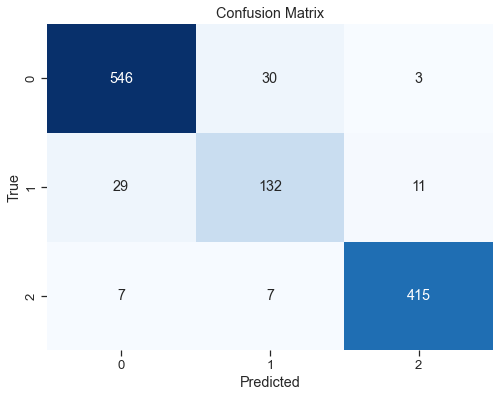

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       579
           1       0.78      0.77      0.77       172
           2       0.97      0.97      0.97       429

    accuracy                           0.93      1180
   macro avg       0.90      0.89      0.89      1180
weighted avg       0.93      0.93      0.93      1180



In [64]:
test_final_model(final_model, X_test, y_test, svd)

# 5th train-test split

In [65]:
X, X_test, y, y_test = choose_split(splits, 4)

(2752, 2000)
(1180, 2000)
(2752, 1)
(1180, 1)


In [66]:
X

,ORM1,ORM2,MMP3,FDCSP,S100A7,FABP7,KRT81,DCN,IL1B,AREG,...,RP11.597D13.9,MRGPRX4,C2CD4B,CTD.2012K14.8,CCR10,FAS,ADORA2B,PRMT9,PHGDH,HOXA4
0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,2.238069,0.000000,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1.572714,...,0.0,0.0,0.0,0.0,0.0,0.000000,1.572714,0.0,0.000000,0.0
2,0.0,0.0,0.000000,0.0,0.000000,1.187759,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.760741,0.000000,0.0,0.760741,0.0
3,0.0,0.0,2.315123,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
4,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.701552,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2747,0.0,0.0,4.449793,0.0,0.000000,0.000000,0.000000,0.0,4.905012,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.696767,0.000000,0.0,0.000000,0.0
2748,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.858579,0.0
2749,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
2750,0.0,0.0,0.000000,0.0,1.163421,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.550213,0.000000,0.0,0.000000,0.0


### NestedCV to optimize each model and compare them

In [67]:
X.shape

(2752, 2000)

In [68]:
X.loc[[0,1,2,3]]


,ORM1,ORM2,MMP3,FDCSP,S100A7,FABP7,KRT81,DCN,IL1B,AREG,...,RP11.597D13.9,MRGPRX4,C2CD4B,CTD.2012K14.8,CCR10,FAS,ADORA2B,PRMT9,PHGDH,HOXA4
0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,2.238069,0.000000,0.0,0.000000,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,1.572714,...,0.0,0.0,0.0,0.0,0.0,0.000000,1.572714,0.0,0.000000,0.0
2,0.0,0.0,0.000000,0.0,0.0,1.187759,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.760741,0.000000,0.0,0.760741,0.0
3,0.0,0.0,2.315123,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0


In [69]:
results, params_dict = run_all_classifiers(X,y)

Starting NCV experiment for classifier svm


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Starting NCV experiment for classifier lr


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Starting NCV experiment for classifier gnb


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Starting NCV experiment for classifier rf


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Starting NCV experiment for classifier xgb


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [70]:
for key, value in params_dict.items():
    print(f'Params for classifier {key}')
    for idx, param in enumerate(value):
        print(f'Params of trial {idx}: {param}')

Params for classifier svm
Params of trial 0: {'c_svm': 0.965074133910192, 'gamma_svm': 0.002263974397851053}
Params of trial 1: {'c_svm': 0.911708803615447, 'gamma_svm': 0.04666877839748133}
Params of trial 2: {'c_svm': 0.864954986892456, 'gamma_svm': 0.0020401005557499612}
Params of trial 3: {'c_svm': 0.3807954882107248, 'gamma_svm': 0.08311366668633326}
Params of trial 4: {'c_svm': 0.22754301744380323, 'gamma_svm': 0.14639299022346985}
Params of trial 5: {'c_svm': 0.33022196117270297, 'gamma_svm': 0.017628449397609876}
Params of trial 6: {'c_svm': 0.13677484033861703, 'gamma_svm': 0.04744137328105374}
Params of trial 7: {'c_svm': 0.7989527705253978, 'gamma_svm': 0.0042123486611777205}
Params of trial 8: {'c_svm': 0.3952265939237936, 'gamma_svm': 0.005538033762950728}
Params of trial 9: {'c_svm': 0.21692688421131837, 'gamma_svm': 0.01386888460531736}
Params of trial 10: {'c_svm': 0.9102824253788809, 'gamma_svm': 0.001977869066286761}
Params of trial 11: {'c_svm': 0.9812312672083515, '

#### Metrics to compare the algorithms

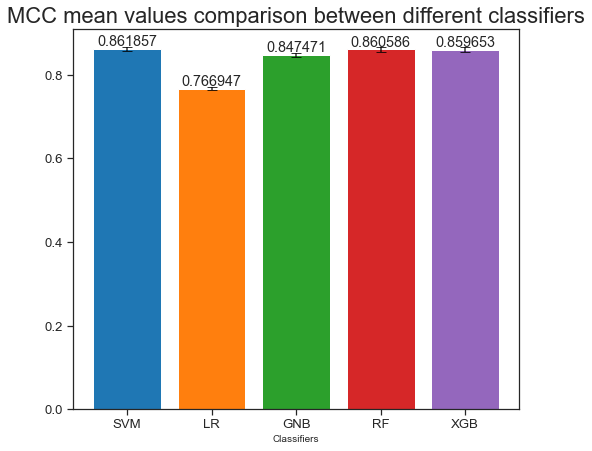

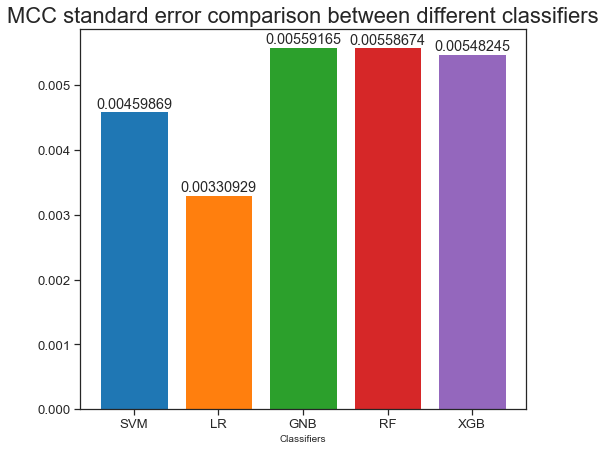

{'svm': 0.861857173848373,
 'lr': 0.7669468728045342,
 'gnb': 0.8474710504098802,
 'rf': 0.8605864245251149,
 'xgb': 0.8596525972973525}

In [71]:
mccs_dict = compare_mean_mccs(results)
mccs_dict

In [72]:
results_df = ncv_results_to_df(results)
results_df

,Classifier,Metric,Outer Loop,Value
0,svm,F1_weighted,1,0.927028
1,svm,F1_weighted,2,0.913162
2,svm,F1_weighted,3,0.891311
3,svm,F1_weighted,4,0.928459
4,svm,F1_weighted,5,0.925931
...,...,...,...,...
595,xgb,Balanced_Accuracy,11,0.869486
596,xgb,Balanced_Accuracy,12,0.894444
597,xgb,Balanced_Accuracy,13,0.877747
598,xgb,Balanced_Accuracy,14,0.907377


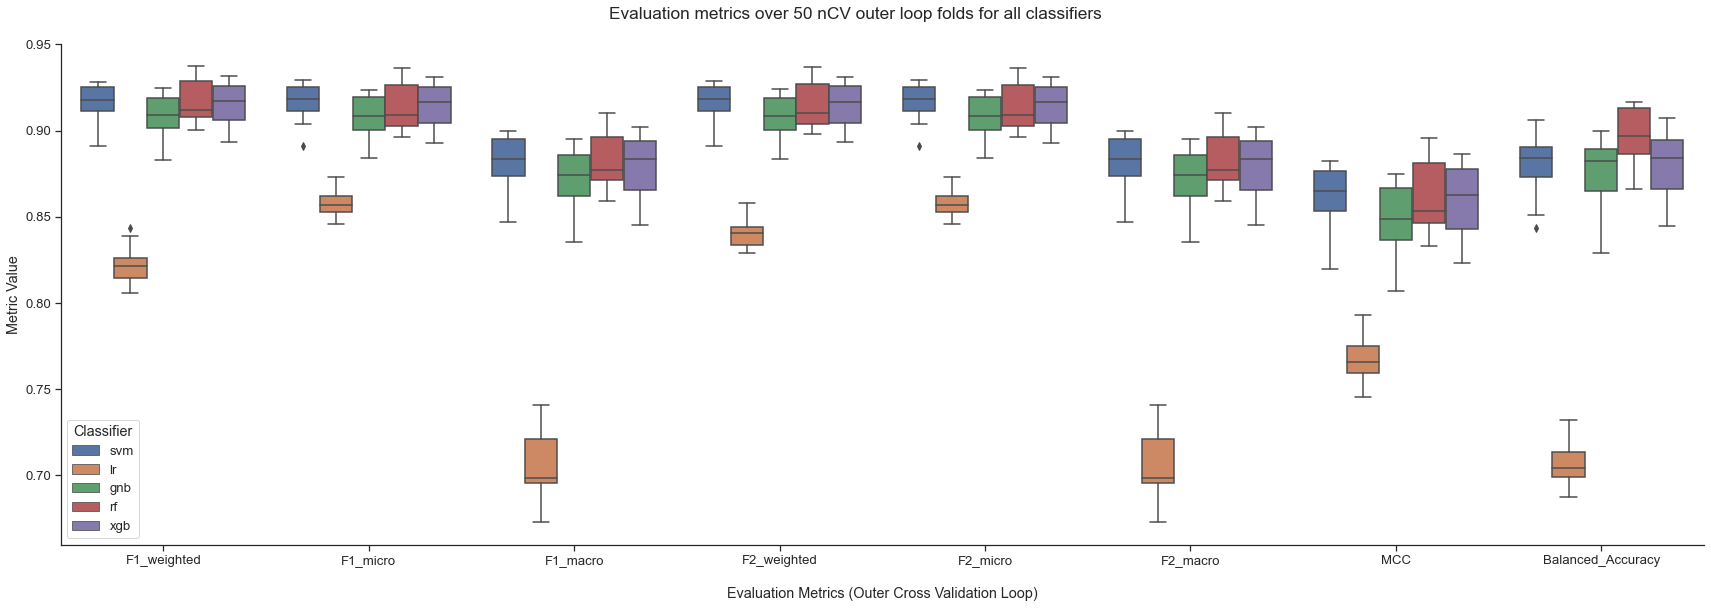

In [73]:
plot_metric_boxplots(results_df)

### 5-fold cross validation to optimize hyperparameters

In [74]:
best_params, best_value = optimize_hyperparameters(X, y)

  0%|          | 0/50 [00:00<?, ?it/s]

Best Hyperparameters: {'c_svm': 0.5043056769914164, 'gamma_svm': 0.0265536064659077}
Best Value: 0.8683197754905626


## Build final model

In [75]:
final_model, svd = build_final_model(X, y, best_params)
final_model

OneVsRestClassifier(estimator=SVC(C=0.5043056769914164,
                                  gamma=0.0265536064659077, max_iter=1000,
                                  random_state=42),
                    n_jobs=-1)

## Test on held-out test set

In [76]:
X_test

,ORM1,ORM2,MMP3,FDCSP,S100A7,FABP7,KRT81,DCN,IL1B,AREG,...,RP11.597D13.9,MRGPRX4,C2CD4B,CTD.2012K14.8,CCR10,FAS,ADORA2B,PRMT9,PHGDH,HOXA4
0,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,0.0,0.757296,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.757296,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1.541966,0.0
3,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,3.342148,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
4,0.0,0.000000,0.000000,0.0,4.259858,0.00000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.812531,...,0.0,0.0,0.000000,0.0,0.0,0.812531,0.0,0.0,0.000000,0.0
1176,0.0,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1177,0.0,0.000000,0.000000,0.0,0.000000,1.09582,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,1.095820,0.0
1178,0.0,0.000000,3.810159,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,1.480863,0.0,0.0,0.000000,0.0


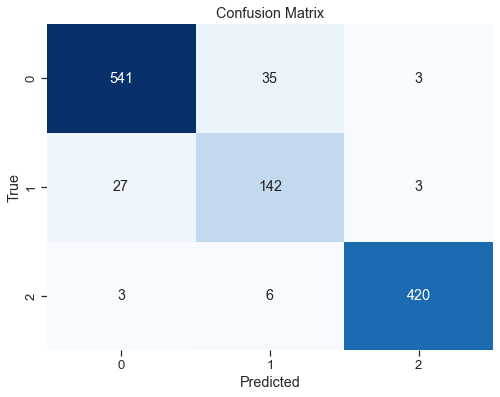

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       579
           1       0.78      0.83      0.80       172
           2       0.99      0.98      0.98       429

    accuracy                           0.93      1180
   macro avg       0.90      0.91      0.91      1180
weighted avg       0.94      0.93      0.94      1180



In [77]:
test_final_model(final_model, X_test, y_test, svd)